In [1]:
%cd ..

/Users/bdhammel/Documents/insight/harvesting


In [2]:
%matplotlib inline 

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)

import matplotlib.pyplot as plt
from models.retinanet.keras_retinanet.models.retinanet import custom_objects
import pipeline.utils as pipe_utils
from skimage.transform import resize as skresize
from pipeline.raw_data import clean_dota
from pipeline import obj_pipeline
from PIL import Image, ImageDraw
import glob
import os
import csv
import keras

SNAPSHOT_DIR = os.path.join(os.getcwd(), 'models/saved_models')
IMAGE_DIR = os.path.join(os.getcwd(), 'datasets/raw_images')

processor = clean_dota.dota_processor(block_shape=(400,400,3))

MAP_ID_TO_LABEL = {}
with open('datasets/obj_detection/dota/classes.csv', 'r') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        label, id_ = row
        MAP_ID_TO_LABEL[int(id_)] = label        

Using TensorFlow backend.


In [3]:
model_path = os.path.join(SNAPSHOT_DIR, 'trained_full.h5')
model = keras.models.load_model(model_path, custom_objects=custom_objects)

/usr/local/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


Image test11.png loaded
	Shape:  (400, 400, 3)
	dtype:  uint8
Values: (65.00,255.00)


(-0.5, 399.5, 399.5, -0.5)

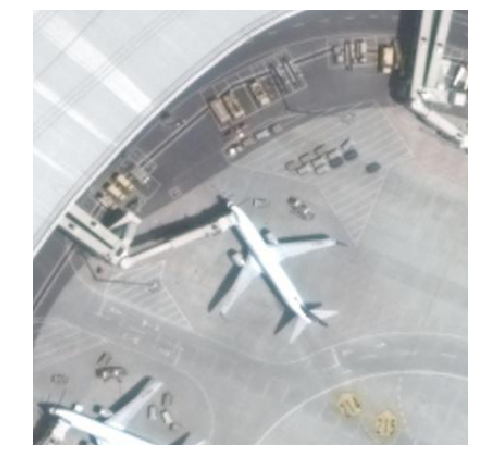

In [4]:
image_path = os.path.join(IMAGE_DIR, 'test11.png')
data = pipe_utils.read_raw_image(image_path)
data = skresize(data, (400,400,3), mode='reflect', preserve_range=True)
plt.figure(figsize=(8,8))
plt.imshow(data/255)
plt.axis('off')

In [5]:
def preprocess(data):
    # Preprocess for RetinaNet
    X = np.copy(data[...,::-1]).astype(np.float32)
    X = X.reshape((-1,400,400,3))
    X[...,0] -= 103.939
    X[...,1] -= 116.779
    X[...,2] -= 123.68
    return X

In [6]:
X = preprocess(data)
predictions = model.predict(X, batch_size=1)
*_, detections = predictions

In [7]:
threshold=.05
objs = []
for potential_obj in detections[0]:
    if np.any(potential_obj[4:]>threshold):
        objs.append(potential_obj)
objs = np.asarray(objs)
obj_labels = [MAP_ID_TO_LABEL[id_] for id_ in np.argmax(objs[:,4:], axis=1)]

In [8]:
print("{} objects found in the image".format(len(objs)))
print("Found: ")
for obj in obj_labels:
    print("\t", obj)

2 objects found in the image
Found: 
	 plane
	 plane


(-0.5, 399.5, 399.5, -0.5)

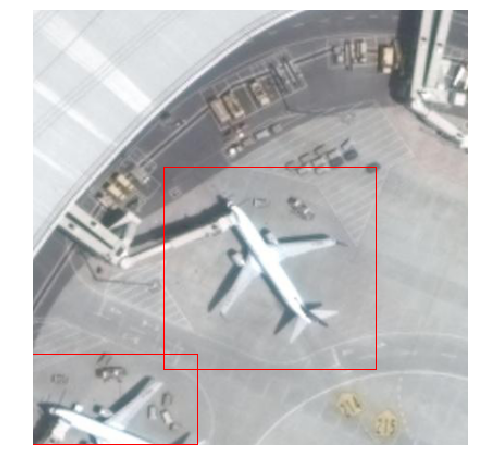

In [9]:
plt.figure(figsize=(8,8))
img = Image.fromarray(data.astype(np.uint8))
draw = ImageDraw.Draw(img) 
for obj in objs:
    draw.rectangle(
        obj[:4],
        outline='red'
    )

plt.imshow(np.asarray(img))
plt.axis('off')

Image test12.png loaded
	Shape:  (5502, 3875, 3)
	dtype:  uint8
Values: (0.00,255.00)


(-0.5, 3874.5, 5501.5, -0.5)

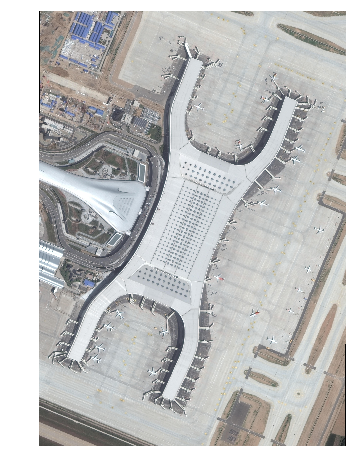

In [10]:
image_path = os.path.join(IMAGE_DIR, 'test12.png')
img = pipe_utils.read_raw_image(image_path) #[...,:3]
pipe_utils.data_is_ok(img, raise_exception=True)
plt.figure(figsize=(8,8))
plt.imshow(img/255)
plt.axis('off')

In [11]:
blocks = pipe_utils.chop_to_blocks(img, (400,400,3) )

In [12]:
jmx, imx, *_ = blocks.shape
block_index = []
orgX = []
for j in range(jmx):
    for i in range(imx):
        orgX.append(blocks[j, i, 0, ...])
        block_index.append((i, j))

In [13]:
X = np.array(orgX, copy=True)
X = preprocess(X)
*_, org_detections = model.predict(X, batch_size=1)

In [14]:
threshold=.4
objs = []
obj_labels = []
detections = np.copy(org_detections)
_debug = []
for idx, detection_patch in enumerate(detections):
    i, j = block_index[idx]
    for potential_obj in detection_patch:
        if np.any(potential_obj[4:]>threshold):
            objs.append(
                {'coor':(
                    (potential_obj[0] + i*400, #x0
                    potential_obj[1] + j*400), #y0
                    (potential_obj[2] + i*400, #x1
                    potential_obj[3] + j*400) #y1
                    ),
                 'label_id':np.argmax(detection_patch[4:])
            })
            _debug.append((i,j))

In [15]:
im = Image.fromarray(img)
artist = ImageDraw.Draw(im)
for obj in objs:
    artist.rectangle(
        obj['coor'],
        outline='red',
    )

(-0.5, 3874.5, 5501.5, -0.5)

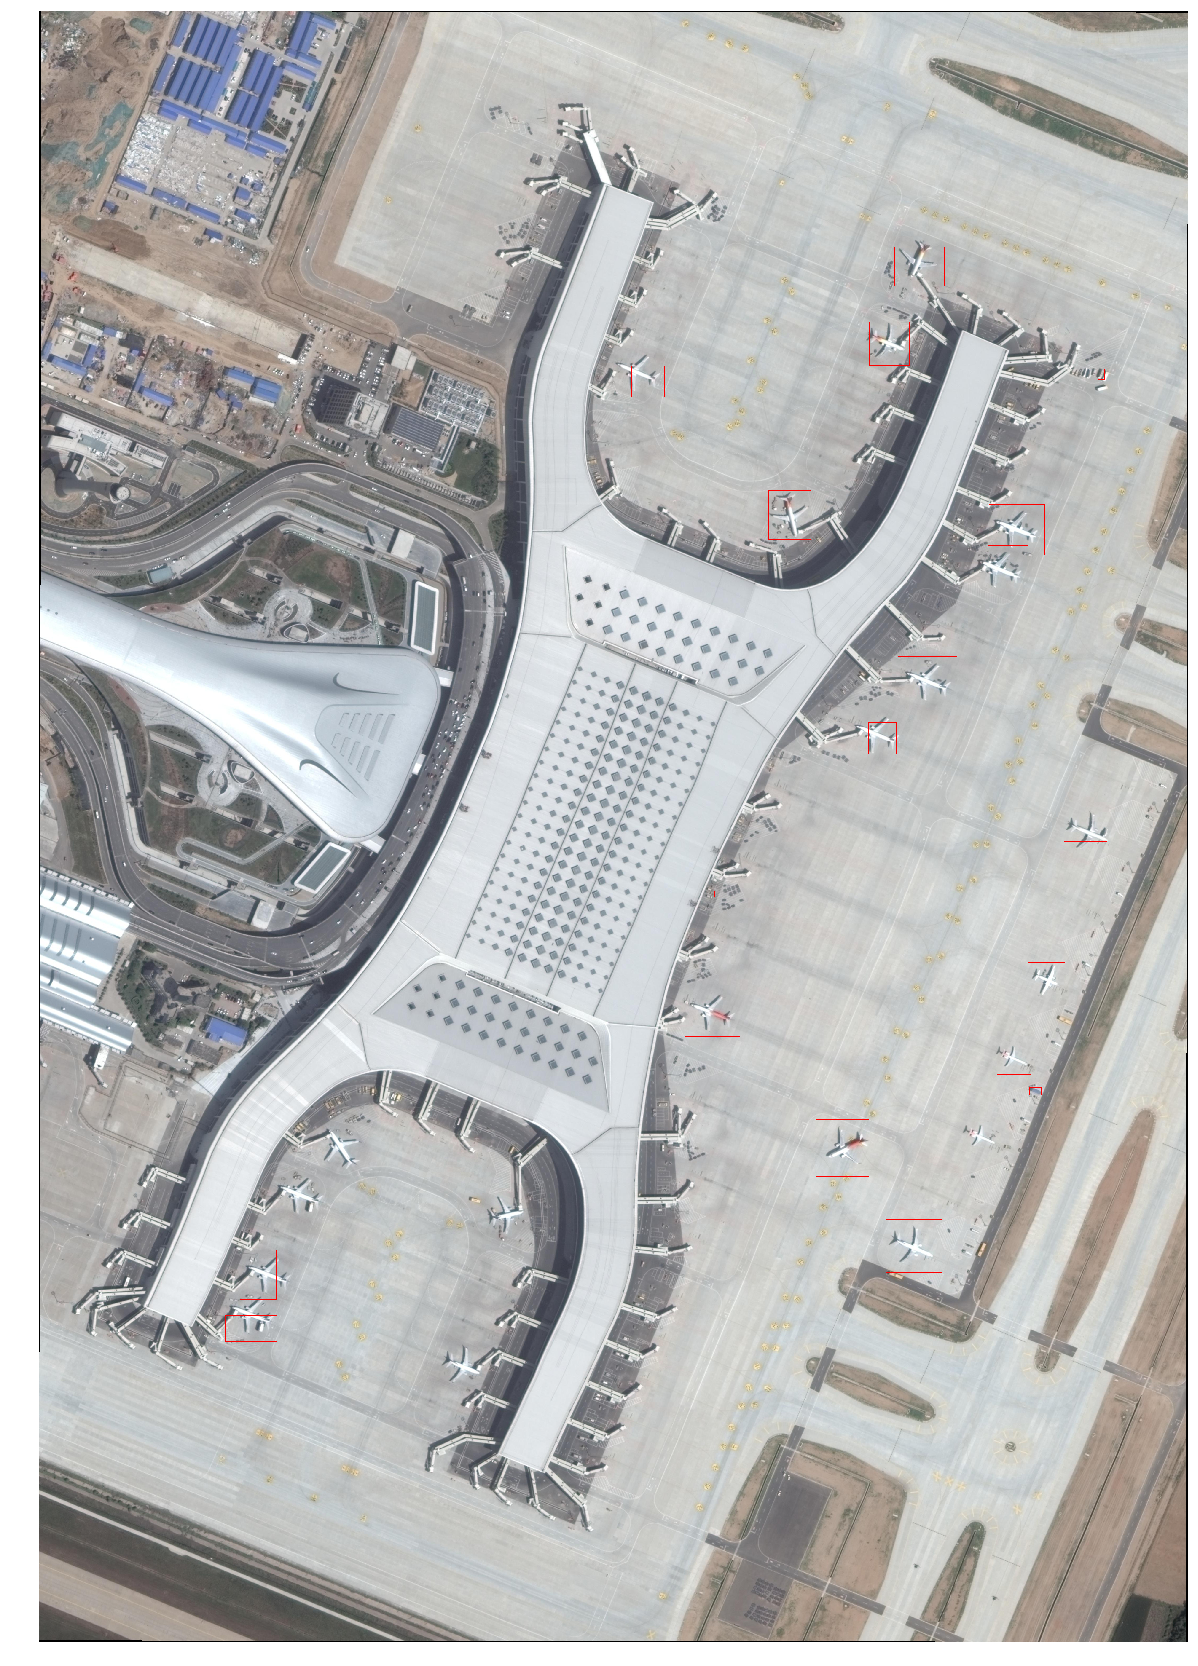

In [20]:
plt.figure(figsize=(30,30))
plt.imshow(np.asarray(im))
plt.axis('off')